In [1]:
import os
import tensorflow as tf
print(tf.__version__)
import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import numpy as np

2.0.0-rc0


Using TensorFlow backend.


In [2]:
def load_image(path,size=(256,512)):
    A_list=[]
    B_list=[]
    for filename in os.listdir(path):
        img=load_img(os.path.join(path,filename),target_size=size)
        img=img_to_array(img)
        A,B=img[:,:256],img[:,256:]
        A_list.append(A)
        B_list.append(B)
    return np.asarray(A_list),np.asarray(B_list)

In [3]:
path='maps//train'
trainA,trainB=load_image(path)
print(trainA.shape)
print(trainB.shape)

(1096, 256, 256, 3)
(1096, 256, 256, 3)


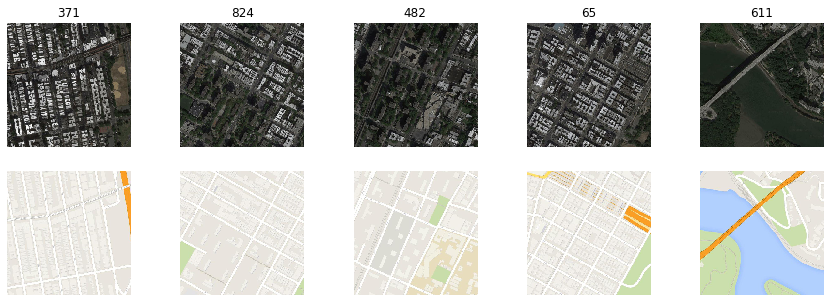

In [4]:
randi=np.random.randint(0,len(trainA),5)
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(trainA[randi[i]].astype(int))
    plt.axis('off')
    plt.title(randi[i])
    plt.subplot(2,5,i+1+5)
    plt.imshow(trainB[randi[i]].astype(int))
    plt.axis('off')
plt.show()

# Discriminator
PatchGAN Discriminator  
![Pix2Pix](https://i.imgur.com/4kXeZA7.jpg)  
![PatchGAN](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Plot-of-the-PatchGAN-Model-Used-in-the-Pix2Pix-GAN-Architecture-453x1024.png)  

output為16\*16\*1  
__receptive field: 70->34->16->7->4->1=output layer__  

In [5]:
#PatchGAN Discriminator
def discriminator(input_shape=(256,256,3)):
    init=keras.initializers.RandomNormal(stddev=0.02)
    
    source_input=keras.models.Input(shape=input_shape)
    target_input=keras.models.Input(shape=input_shape)
    merge=keras.layers.Concatenate()([source_input,target_input])
    #1th
    x=keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(merge)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #2nd
    x=keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #3rd
    x=keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #4th
    x=keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #5th
    x=keras.layers.Conv2D(512,(4,4),padding='same',kernel_initializer=init)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #6th
    x=keras.layers.Conv2D(1,(4,4),padding='same',kernel_initializer=init)(x)
    patch_output=keras.layers.Activation('sigmoid')(x)
    
    model=keras.models.Model(inputs=[source_input,target_input],outputs=patch_output,name='discriminator')
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
    return model

In [6]:
discriminator((256,256,3)).summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
___________________________________________________________________________________________

# Generator
U-Net示意圖（並非pix2pix所用）：  
![U-Net](https://pic3.zhimg.com/v2-5e139aa944458db48c7b1bdab3266264_1200x500.jpg)  
The generator is an encoder-decoder model using a U-Net architecture. <font color='ff0000'>__The model takes a source image (e.g. satellite photo) and generates a target image (e.g. Google maps image).__</font> It does this by first downsampling or encoding the input image down to a <font color='#dd00dd'>__bottleneck layer__</font>, then upsampling or decoding the bottleneck representation to the size of the output image. The U-Net architecture means that <font color='#dd00dd'>__skip-connections__</font> are added between the encoding layers and the corresponding decoding layers, forming a U-shape.

### Encoder block
Conv-BN-LeakyReLU  

In [7]:
#Conv-BN-LeakyReLU
def encoder_block(layer_in,n_filters,bn=True):
    init=keras.initializers.RandomNormal(stddev=0.02)
    
    x=keras.layers.Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    if bn==True:
        #update BN's four parameters even in testing
        x=keras.layers.BatchNormalization()(x,training=True)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

### Decoder block
ConvT-BN-Dropout-ReLU  

In [8]:
#ConvT-BN-Dropout-ReLU
def decoder_block(layer_in,skip_in,n_filters,drop=True):
    init=keras.initializers.RandomNormal(stddev=0.02)
    
    x=keras.layers.Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    x=keras.layers.BatchNormalization()(x,training=True)
    if drop==True:
        x=keras.layers.Dropout(0.5)(x,training=True)
    x=keras.layers.Concatenate()([x,skip_in])
    x=keras.layers.ReLU()(x)
    return x

### U-Net Generator
![generator](https://1.bp.blogspot.com/-haSyv2FO7NI/XYTKOsTIyoI/AAAAAAAAErg/Dd-eBSS3gPo7FiCMWFQxeWtg-q0u8eOVwCLcBGAsYHQ/s640/IMG_2364.JPG)    

In [9]:
def generator(input_shape=(256,256,3)):
    init=keras.initializers.RandomNormal(stddev=0.02)
    
    input_x=keras.models.Input(shape=input_shape)
    #encoder(first layer doesn't do BN)
    e1=encoder_block(input_x,64,bn=False)
    e2=encoder_block(e1,128)
    e3=encoder_block(e2,256)
    e4=encoder_block(e3,512)
    e5=encoder_block(e4,512)
    e6=encoder_block(e5,512)
    e7=encoder_block(e6,512)
    #bottleneck layer
    b=keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    b=keras.layers.ReLU()(b)
    #decoder
    d1=decoder_block(b,e7,512)
    d2=decoder_block(d1,e6,512)
    d3=decoder_block(d2,e5,512)
    d4=decoder_block(d3,e4,512,drop=False)
    d5=decoder_block(d4,e3,256,drop=False)
    d6=decoder_block(d5,e2,128,drop=False)
    d7=decoder_block(d6,e1,64,drop=False)
    #output
    x=keras.layers.Conv2DTranspose(3,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    x=keras.layers.Activation('tanh')(x)
    
    model=keras.models.Model(inputs=input_x,outputs=x,name='generator')
    return model

In [10]:
generator().summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_6[0][0]              
__________________________________________________________________________________________

# Loss Function
loss function = adversarial loss + L1 loss(mean absolute error)  
* adversarial loss: 為了產生target domain的fake image
* L1 loss: 為了讓fake image看起來像input image

![loss function](https://1.bp.blogspot.com/-6x84d2gg4aM/XYTR-lqGx2I/AAAAAAAAErs/3WuMC8NFVkcpAyoC9A886nY67l9SvpKIQCLcBGAsYHQ/s640/IMG_2367.JPG)  

# composite model
權重比1:100,代表"生成的圖片要像原圖"比"轉換Domain style"重要  

In [11]:
def gan(g_model,d_model,input_shape=(256,256,3)):
    d_model.trainable=False
    input_source=keras.models.Input(shape=input_shape)
    gen_out=g_model(input_source)
    dis_out=d_model([input_source,gen_out])
    
    model=keras.Model(inputs=input_source,outputs=[dis_out,gen_out],name='composite model')
    model.compile(loss=['binary_crossentropy','mae'],optimizer=keras.optimizers.Adam(lr=0.0002,beta_1=0.5),loss_weights=[1,100])
    return model

# Train
用batch_size=1  
當batch_size=1的BN == IN  

In [12]:
def real_image_generator(trainA,trainB,num,patch_size):
    randi=np.random.randint(0,len(trainA),num)
    A=trainA[randi]
    B=trainB[randi]
    y=np.ones((num,*patch_size))
    
    return [A,B],y

設一 image:P與對應的image Q  
用(P,Q)＆(P,fakeQ) train discriminator  

In [13]:
def fake_image_generator(g_model,samples,patch_size):
    B=g_model.predict(samples)
    y=np.zeros((len(samples),*patch_size))
    
    return [samples,B],y

In [14]:
def fit(g_model,d_model,composite_model,trainA,trainB,epochs=5,batch_size=1):
    patch_size=d_model.output_shape[1:]
    batchs=len(trainA)//batch_size
    his_loss_d1=[]
    his_loss_d2=[]
    his_loss_g=[]
    for epoch in range(1,epochs+1):
        for batch in range(1,batchs+1):
            #train discrimanator
            [realA,realB],realy=real_image_generator(trainA,trainB,batch_size,patch_size)
            loss_d1=d_model.train_on_batch([realA,realB],realy)
            [realA,fakeB],fakey=fake_image_generator(g_model,realA,patch_size)
            loss_d2=d_model.train_on_batch([realA,fakeB],fakey)
            #train generator
            loss_g,_,_=composite_model.train_on_batch(realA,[realy,realB])
            if batch%100==0:
                print('epoch{} {}/{} loss_d1:{:.2f},loss_d2:{:.2f},loss_g:{:.2f}'.format(epoch,batch,batchs,loss_d1,loss_d2,loss_g))
            if batch==batchs:
                his_loss_d1.append(loss_d1)
                his_loss_d2.append(loss_d2)
                his_loss_g.append(loss_g)
        summarize(epoch,trainA,trainB,g_model)
    return his_loss_d1,his_loss_d2,his_loss_g

In [15]:
def summarize(epoch,trainA,trainB,g_model):
    #save model
    g_model.save('Pix2Pix GAN//generator {}.h5'.format(epoch))
    #save picture
    [realA,realB],_=real_image_generator(trainA,trainB,num=5,patch_size=(1,))
    [realA,fakeB],_=fake_image_generator(g_model,samples=realA,patch_size=(1,))
    realA=(realA+1)/2
    realB=(realB+1)/2
    fakeB=(fakeB+1)/2
    plt.figure(figsize=(15,8))
    for i in range(5):
        #realA
        plt.subplot(3,5,i+1)
        plt.imshow(realA[i])
        plt.axis('off')
        #fakeB
        plt.subplot(3,5,i+1+5)
        plt.imshow(fakeB[i])
        plt.axis('off')
        #realB
        plt.subplot(3,5,i+1+10)
        plt.imshow(realB[i])
        plt.axis('off')
    plt.savefig('Pix2Pix GAN//epoch {}.png'.format(epoch))
    plt.close()

# Start GAN

from \[0,255\] -> \[-1,1\]  

In [16]:
path='maps//train'
trainA,trainB=load_image(path)
trainA=(trainA-127.5)/127.5
trainB=(trainB-127.5)/127.5
print(trainA.shape)
print(trainB.shape)
print(trainA[0,:3,:3,:])

(1096, 256, 256, 3)
(1096, 256, 256, 3)
[[[-0.7490196  -0.7490196  -0.7490196 ]
  [-0.7254902  -0.7254902  -0.7254902 ]
  [-0.81960785 -0.81960785 -0.81960785]]

 [[-0.79607844 -0.79607844 -0.79607844]
  [-0.7411765  -0.7411765  -0.7411765 ]
  [-0.79607844 -0.79607844 -0.79607844]]

 [[-0.7490196  -0.7490196  -0.7490196 ]
  [-0.77254903 -0.77254903 -0.77254903]
  [-0.81960785 -0.81960785 -0.81960785]]]


In [17]:
g_model=generator(trainA.shape[1:])
d_model=discriminator(trainA.shape[1:])
c_model=gan(g_model,d_model,trainA.shape[1:])
his_loss_d1,his_loss_d2,his_loss_g=fit(g_model,d_model,c_model,trainA,trainB,epochs=100,batch_size=1)

/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch1 100/1096 loss_d1:0.91,loss_d2:0.43,loss_g:19.74
epoch1 200/1096 loss_d1:0.09,loss_d2:0.18,loss_g:16.37
epoch1 300/1096 loss_d1:0.01,loss_d2:0.09,loss_g:13.34
epoch1 400/1096 loss_d1:0.14,loss_d2:0.12,loss_g:13.37
epoch1 500/1096 loss_d1:0.02,loss_d2:0.06,loss_g:11.90
epoch1 600/1096 loss_d1:0.01,loss_d2:0.24,loss_g:28.93
epoch1 700/1096 loss_d1:1.53,loss_d2:0.06,loss_g:16.50
epoch1 800/1096 loss_d1:0.32,loss_d2:0.14,loss_g:10.41
epoch1 900/1096 loss_d1:0.45,loss_d2:0.08,loss_g:10.14
epoch1 1000/1096 loss_d1:0.00,loss_d2:0.04,loss_g:14.29
epoch2 100/1096 loss_d1:0.01,loss_d2:0.04,loss_g:11.79
epoch2 200/1096 loss_d1:0.19,loss_d2:0.12,loss_g:13.68
epoch2 300/1096 loss_d1:0.00,loss_d2:0.15,loss_g:14.00
epoch2 400/1096 loss_d1:0.90,loss_d2:0.22,loss_g:8.82
epoch2 500/1096 loss_d1:0.20,loss_d2:0.18,loss_g:9.18
epoch2 600/1096 loss_d1:0.04,loss_d2:0.46,loss_g:12.45
epoch2 700/1096 loss_d1:0.60,loss_d2:0.39,loss_g:8.90
epoch2 800/1096 loss_d1:0.00,loss_d2:0.05,loss_g:18.59
epoch2 900/1

epoch15 1000/1096 loss_d1:0.08,loss_d2:0.05,loss_g:11.47
epoch16 100/1096 loss_d1:0.01,loss_d2:0.34,loss_g:12.72
epoch16 200/1096 loss_d1:0.08,loss_d2:0.02,loss_g:9.53
epoch16 300/1096 loss_d1:0.04,loss_d2:0.06,loss_g:9.34
epoch16 400/1096 loss_d1:0.01,loss_d2:0.00,loss_g:9.83
epoch16 500/1096 loss_d1:0.03,loss_d2:0.00,loss_g:16.46
epoch16 600/1096 loss_d1:0.01,loss_d2:0.08,loss_g:10.16
epoch16 700/1096 loss_d1:0.00,loss_d2:0.00,loss_g:15.91
epoch16 800/1096 loss_d1:0.46,loss_d2:0.54,loss_g:10.07
epoch16 900/1096 loss_d1:0.00,loss_d2:0.01,loss_g:15.48
epoch16 1000/1096 loss_d1:0.00,loss_d2:0.10,loss_g:16.15
epoch17 100/1096 loss_d1:0.22,loss_d2:0.07,loss_g:9.78
epoch17 200/1096 loss_d1:0.24,loss_d2:0.04,loss_g:6.47
epoch17 300/1096 loss_d1:1.33,loss_d2:0.11,loss_g:6.63
epoch17 400/1096 loss_d1:0.00,loss_d2:0.02,loss_g:12.24
epoch17 500/1096 loss_d1:0.00,loss_d2:0.06,loss_g:12.20
epoch17 600/1096 loss_d1:0.00,loss_d2:0.00,loss_g:14.07
epoch17 700/1096 loss_d1:0.69,loss_d2:0.01,loss_g:13

epoch30 700/1096 loss_d1:0.00,loss_d2:0.32,loss_g:12.22
epoch30 800/1096 loss_d1:0.01,loss_d2:0.04,loss_g:14.26
epoch30 900/1096 loss_d1:1.30,loss_d2:0.66,loss_g:9.87
epoch30 1000/1096 loss_d1:0.00,loss_d2:0.00,loss_g:10.16
epoch31 100/1096 loss_d1:0.05,loss_d2:0.01,loss_g:12.12
epoch31 200/1096 loss_d1:0.41,loss_d2:0.03,loss_g:11.21
epoch31 300/1096 loss_d1:0.01,loss_d2:0.03,loss_g:7.16
epoch31 400/1096 loss_d1:0.00,loss_d2:0.00,loss_g:14.91
epoch31 500/1096 loss_d1:0.00,loss_d2:0.36,loss_g:13.52
epoch31 600/1096 loss_d1:0.03,loss_d2:0.02,loss_g:10.26
epoch31 700/1096 loss_d1:0.00,loss_d2:0.07,loss_g:11.73
epoch31 800/1096 loss_d1:0.04,loss_d2:0.00,loss_g:14.63
epoch31 900/1096 loss_d1:0.00,loss_d2:0.00,loss_g:10.02
epoch31 1000/1096 loss_d1:0.00,loss_d2:0.02,loss_g:11.46
epoch32 100/1096 loss_d1:0.04,loss_d2:0.06,loss_g:7.31
epoch32 200/1096 loss_d1:0.91,loss_d2:0.01,loss_g:9.50
epoch32 300/1096 loss_d1:1.55,loss_d2:0.09,loss_g:12.26
epoch32 400/1096 loss_d1:0.16,loss_d2:0.00,loss_g:

epoch45 400/1096 loss_d1:0.02,loss_d2:0.00,loss_g:9.21
epoch45 500/1096 loss_d1:0.00,loss_d2:0.01,loss_g:9.81
epoch45 600/1096 loss_d1:0.03,loss_d2:0.09,loss_g:7.63
epoch45 700/1096 loss_d1:0.11,loss_d2:0.01,loss_g:10.39
epoch45 800/1096 loss_d1:0.00,loss_d2:0.01,loss_g:6.13
epoch45 900/1096 loss_d1:0.00,loss_d2:0.04,loss_g:4.78
epoch45 1000/1096 loss_d1:0.02,loss_d2:0.02,loss_g:10.44
epoch46 100/1096 loss_d1:0.00,loss_d2:0.90,loss_g:18.80
epoch46 200/1096 loss_d1:0.06,loss_d2:0.00,loss_g:11.59
epoch46 300/1096 loss_d1:0.00,loss_d2:0.15,loss_g:11.48
epoch46 400/1096 loss_d1:0.01,loss_d2:0.05,loss_g:8.22
epoch46 500/1096 loss_d1:0.08,loss_d2:0.08,loss_g:10.28
epoch46 600/1096 loss_d1:0.17,loss_d2:0.05,loss_g:12.44
epoch46 700/1096 loss_d1:0.00,loss_d2:0.01,loss_g:13.79
epoch46 800/1096 loss_d1:0.01,loss_d2:0.07,loss_g:10.74
epoch46 900/1096 loss_d1:0.02,loss_d2:0.00,loss_g:15.74
epoch46 1000/1096 loss_d1:0.34,loss_d2:0.05,loss_g:7.92
epoch47 100/1096 loss_d1:0.00,loss_d2:0.01,loss_g:12.

epoch60 200/1096 loss_d1:0.57,loss_d2:0.23,loss_g:9.38
epoch60 300/1096 loss_d1:0.54,loss_d2:0.00,loss_g:10.42
epoch60 400/1096 loss_d1:1.27,loss_d2:0.02,loss_g:6.10
epoch60 500/1096 loss_d1:0.01,loss_d2:0.54,loss_g:9.79
epoch60 600/1096 loss_d1:0.20,loss_d2:0.02,loss_g:9.17
epoch60 700/1096 loss_d1:0.03,loss_d2:0.01,loss_g:10.92
epoch60 800/1096 loss_d1:0.00,loss_d2:0.14,loss_g:14.15
epoch60 900/1096 loss_d1:0.00,loss_d2:0.13,loss_g:9.70
epoch60 1000/1096 loss_d1:0.04,loss_d2:0.04,loss_g:9.47
epoch61 100/1096 loss_d1:0.16,loss_d2:0.12,loss_g:10.20
epoch61 200/1096 loss_d1:0.04,loss_d2:0.01,loss_g:10.35
epoch61 300/1096 loss_d1:0.99,loss_d2:0.04,loss_g:8.62
epoch61 400/1096 loss_d1:0.09,loss_d2:0.05,loss_g:8.90
epoch61 500/1096 loss_d1:0.04,loss_d2:0.05,loss_g:8.08
epoch61 600/1096 loss_d1:0.00,loss_d2:0.05,loss_g:11.59
epoch61 700/1096 loss_d1:0.01,loss_d2:0.04,loss_g:9.92
epoch61 800/1096 loss_d1:0.00,loss_d2:0.10,loss_g:7.27
epoch61 900/1096 loss_d1:0.01,loss_d2:0.14,loss_g:11.35
ep

epoch74 1000/1096 loss_d1:0.07,loss_d2:0.03,loss_g:10.56
epoch75 100/1096 loss_d1:0.01,loss_d2:0.02,loss_g:12.86
epoch75 200/1096 loss_d1:0.05,loss_d2:0.04,loss_g:10.44
epoch75 300/1096 loss_d1:0.00,loss_d2:0.07,loss_g:8.53
epoch75 400/1096 loss_d1:0.00,loss_d2:0.00,loss_g:7.57
epoch75 500/1096 loss_d1:0.01,loss_d2:0.13,loss_g:10.69
epoch75 600/1096 loss_d1:0.44,loss_d2:0.07,loss_g:10.79
epoch75 700/1096 loss_d1:0.00,loss_d2:0.01,loss_g:20.74
epoch75 800/1096 loss_d1:0.01,loss_d2:0.00,loss_g:9.33
epoch75 900/1096 loss_d1:0.14,loss_d2:0.01,loss_g:12.35
epoch75 1000/1096 loss_d1:0.04,loss_d2:0.04,loss_g:10.39
epoch76 100/1096 loss_d1:0.03,loss_d2:0.01,loss_g:11.35
epoch76 200/1096 loss_d1:0.55,loss_d2:0.21,loss_g:6.87
epoch76 300/1096 loss_d1:0.01,loss_d2:0.12,loss_g:9.74
epoch76 400/1096 loss_d1:0.16,loss_d2:0.02,loss_g:6.13
epoch76 500/1096 loss_d1:0.03,loss_d2:0.05,loss_g:7.57
epoch76 600/1096 loss_d1:0.08,loss_d2:0.00,loss_g:12.39
epoch76 700/1096 loss_d1:0.01,loss_d2:0.07,loss_g:10.

epoch89 800/1096 loss_d1:0.19,loss_d2:0.00,loss_g:16.31
epoch89 900/1096 loss_d1:0.01,loss_d2:0.31,loss_g:13.86
epoch89 1000/1096 loss_d1:0.02,loss_d2:0.01,loss_g:5.61
epoch90 100/1096 loss_d1:0.01,loss_d2:0.05,loss_g:8.27
epoch90 200/1096 loss_d1:0.03,loss_d2:0.19,loss_g:9.26
epoch90 300/1096 loss_d1:0.15,loss_d2:0.02,loss_g:8.93
epoch90 400/1096 loss_d1:0.12,loss_d2:0.00,loss_g:12.51
epoch90 500/1096 loss_d1:0.00,loss_d2:0.05,loss_g:8.17
epoch90 600/1096 loss_d1:0.09,loss_d2:0.00,loss_g:10.91
epoch90 700/1096 loss_d1:0.00,loss_d2:0.66,loss_g:14.83
epoch90 800/1096 loss_d1:0.02,loss_d2:0.07,loss_g:9.17
epoch90 900/1096 loss_d1:0.01,loss_d2:0.15,loss_g:10.97
epoch90 1000/1096 loss_d1:0.00,loss_d2:0.02,loss_g:11.43
epoch91 100/1096 loss_d1:0.01,loss_d2:0.01,loss_g:12.20
epoch91 200/1096 loss_d1:0.76,loss_d2:0.15,loss_g:6.87
epoch91 300/1096 loss_d1:0.03,loss_d2:0.02,loss_g:11.15
epoch91 400/1096 loss_d1:0.02,loss_d2:0.01,loss_g:10.47
epoch91 500/1096 loss_d1:0.63,loss_d2:0.26,loss_g:3.7

# plot loss value trend

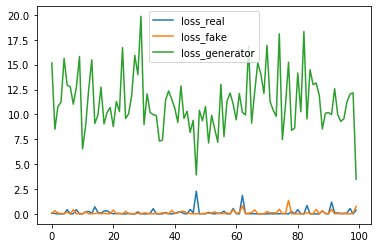

In [18]:
plt.figure()
plt.plot(his_loss_d1,label='loss_real')
plt.plot(his_loss_d2,label='loss_fake')
plt.plot(his_loss_g,label='loss_generator')
plt.legend()
plt.savefig('Pix2Pix GAN//loss value trend.png')

# generate fake image
using validation data to test our model  

In [19]:
path='maps//val'
valA,valB=load_image(path)
valA=(valA-127.5)/127.5
valB=(valB-127.5)/127.5
print(valA.shape)
print(valB.shape)

(1098, 256, 256, 3)
(1098, 256, 256, 3)


In [21]:
g_model=keras.models.load_model('Pix2Pix GAN//generator 100.h5')

/home/dorawu/anaconda3/envs/tf2.0/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


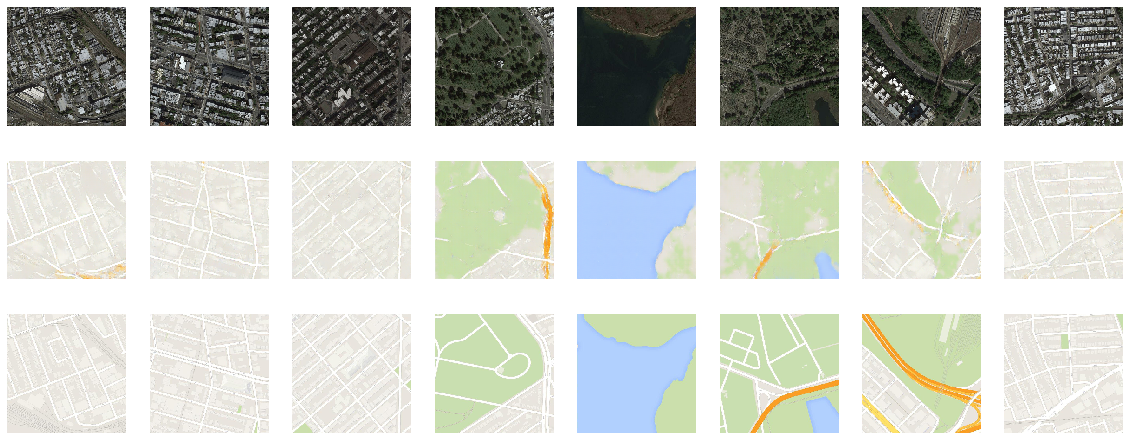

In [22]:
num_test=8
[realA,realB],_=real_image_generator(valA,valB,num=num_test,patch_size=(1,))
[realA,fakeB],_=fake_image_generator(g_model,samples=realA,patch_size=(1,))
realA=(realA+1)/2
realB=(realB+1)/2
fakeB=(fakeB+1)/2
plt.figure(figsize=(20,8))
for i in range(num_test):
    plt.subplot(3,num_test,i+1)
    plt.imshow(realA[i])
    plt.axis('off')
    plt.subplot(3,num_test,i+1+num_test)
    plt.imshow(fakeB[i])
    plt.axis('off')
    plt.subplot(3,num_test,i+1+num_test*2)
    plt.imshow(realB[i])
    plt.axis('off')
plt.savefig('Pix2Pix GAN//test on validation.png')
plt.show()

refernce: https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/  